<a href="https://colab.research.google.com/github/bpushan/AMPBA_G18/blob/FP2/LSTM_Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Implementing a LSTM model for stock price prediction.

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.preprocessing import MinMaxScaler

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [4]:
import math
from sklearn.metrics import mean_squared_error

In [49]:
import matplotlib.pyplot as plt

#### URL of the CSV file on GitHub

In [5]:
url = 'https://raw.githubusercontent.com/bpushan/AMPBA_G18/FP2/stock_prc_data.csv'

In [6]:
# Read the CSV file into a DataFrame
stock_prc_data = pd.read_csv(url)

# Display the DataFrame
print(stock_prc_data.head())

                        Date   HDFC_Open  HDFC_Close    HUL_Open   HUL_Close
0  2012-01-02 00:00:00+05:30  193.554086  192.628967  329.679886  325.035370
1  2012-01-03 00:00:00+05:30  194.682296  198.179718  327.337367  329.518280
2  2012-01-04 00:00:00+05:30  199.420686  200.052475  329.235567  319.421509
3  2012-01-05 00:00:00+05:30  200.368400  200.210449  318.977271  317.725281
4  2012-01-06 00:00:00+05:30  199.014582  204.565323  318.048390  320.511993


#### Getting the prices into dataframes by stocks.

In [7]:
HUL = stock_prc_data[['HUL_Close']].reset_index()
# Rename specific columns
HUL.rename(columns={
    'HUL_Close': 'Close'
}, inplace=True)

HUL[:2]

,index,Close
0,0,325.03537
1,1,329.51828


In [8]:
HDFC = stock_prc_data[['HDFC_Close']].reset_index()
# Rename specific columns
HDFC.rename(columns={
    'HDFC_Close': 'Close'
}, inplace=True)

HDFC[:2]

,index,Close
0,0,192.628967
1,1,198.179718


#### Scaling the data with min-max scaling

In [9]:
scaler=MinMaxScaler(feature_range=(0,1))
HUL = scaler.fit_transform(np.array(HUL).reshape(-1,1))
HDFC = scaler.fit_transform(np.array(HDFC).reshape(-1,1))

#### Splitting dataset into train (70%) and test (30%) split

In [10]:
training_size = int(len(HDFC)*0.7)
test_size = len(HDFC)-training_size
train_data_HDFC, test_data_HDFC = HDFC[0:training_size,:], HDFC[training_size:len(HDFC),:1]

training_size = int(len(HUL)*0.7)
test_size = len(HUL)-training_size
train_data_HUL, test_data_HUL = HUL[0:training_size,:], HUL[training_size:len(HUL),:1]

In [11]:
print("HDFC train, test: ", train_data_HDFC.shape, test_data_HDFC.shape)
print("HUL train, test: ", train_data_HUL.shape, test_data_HDFC.shape)

HDFC train, test:  (4141, 1) (1775, 1)
HUL train, test:  (4141, 1) (1775, 1)


#### Data needs to be arranged in the form
##### priceday-3, priceday-2 priceday-1 => priceday
##### the number of time to be usedis a hyper parameter here.

In [12]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [13]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100

In [14]:
X_train_HDFC, y_train_HDFC = create_dataset(train_data_HDFC, time_step)
X_test_HDFC, y_test_HDFC = create_dataset(test_data_HDFC, time_step)

print("HDFC Train Shape: ", X_train_HDFC.shape, y_train_HDFC.shape)
print("HDFC Test Shape: ", X_test_HDFC.shape, y_test_HDFC.shape)

HDFC Train Shape:  (4040, 100) (4040,)
HDFC Test Shape:  (1674, 100) (1674,)


In [15]:
X_train_HUL, y_train_HUL = create_dataset(train_data_HUL, time_step)
X_test_HUL, y_test_HUL = create_dataset(test_data_HUL, time_step)

print("HUL Train Shape: ", X_train_HUL.shape, y_train_HUL.shape)
print("HUL Test Shape: ", X_test_HUL.shape, y_test_HUL.shape)

HUL Train Shape:  (4040, 100) (4040,)
HUL Test Shape:  (1674, 100) (1674,)


#### Reshape input to be [samples, time steps, features] which is required for LSTM

In [16]:
X_train_HDFC =X_train_HDFC.reshape(X_train_HDFC.shape[0],X_train_HDFC.shape[1] , 1)
X_test_HDFC = X_test_HDFC.reshape(X_test_HDFC.shape[0],X_test_HDFC.shape[1] , 1)

In [17]:
X_train_HUL =X_train_HUL.reshape(X_train_HUL.shape[0],X_train_HUL.shape[1] , 1)
X_test_HUL = X_test_HUL.reshape(X_test_HUL.shape[0],X_test_HUL.shape[1] , 1)

### Create the Stacked LSTM model.

In [31]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
model.fit(X_train_HDFC,y_train_HDFC,validation_data=(X_test_HDFC,y_test_HDFC),epochs=30,batch_size=64,verbose=1)

Epoch 1/30
64/64 [==============================] - 8s 38ms/step - loss: 0.0112 - val_loss: 0.0350
Epoch 2/30
64/64 [==============================] - 1s 16ms/step - loss: 0.0082 - val_loss: 0.0350
Epoch 3/30
64/64 [==============================] - 1s 16ms/step - loss: 0.0083 - val_loss: 0.0401
Epoch 4/30
64/64 [==============================] - 1s 16ms/step - loss: 0.0085 - val_loss: 0.0355
Epoch 5/30
64/64 [==============================] - 1s 15ms/step - loss: 0.0082 - val_loss: 0.0402
Epoch 6/30
64/64 [==============================] - 1s 16ms/step - loss: 0.0084 - val_loss: 0.0352
Epoch 7/30
64/64 [==============================] - 1s 16ms/step - loss: 0.0083 - val_loss: 0.0358
Epoch 8/30
64/64 [==============================] - 1s 16ms/step - loss: 0.0081 - val_loss: 0.0366
Epoch 9/30
64/64 [==============================] - 1s 16ms/step - loss: 0.0085 - val_loss: 0.0372
Epoch 10/30
64/64 [==============================] - 1s 17ms/step - loss: 0.0083 - val_loss: 0.0364
Epoch 11/

#### Lets Do the prediction and check performance metrics

In [34]:
train_predict=model.predict(X_train_HDFC)
test_predict=model.predict(X_test_HDFC)

53/53 [==============================] - 0s 6ms/step


####Transformback to original form

In [35]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

#### Calculate RMSE performance metrics

In [36]:
math.sqrt(mean_squared_error(y_train_HDFC,train_predict))

997.8562961213318

#### Test Data RMSE

In [37]:
math.sqrt(mean_squared_error(y_test_HDFC,test_predict))

2022.944113756006

#### Predict for HDFC.

In [38]:
len(test_data_HDFC)

1775

In [39]:
x_input=test_data_HDFC[1675:].reshape(1,-1)
x_input.shape

(1, 100)

In [40]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

#### Predicting for next 200 days.

In [42]:
HDFC_output=[]
n_steps=100
i=0
while(i <= 200):

    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        HDFC_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        HDFC_output.extend(yhat.tolist())
        i=i+1


print(HDFC_output)

[[0.59577476978302], [0.6128459572792053], [0.5950160026550293], [0.6115084886550903], [0.5942681431770325], [0.6102065443992615], [0.5935310125350952], [0.6089386343955994], [0.5928046107292175], [0.6077035665512085], [0.5920892357826233], [0.6065002083778381], [0.5913844704627991], [0.6053274869918823], [0.5906902551651001], [0.604184091091156], [0.5900068879127502], [0.6030691862106323], [0.5893338322639465], [0.6019819378852844], [0.588671088218689], [0.6009213328361511], [0.5880187153816223], [0.5998863577842712], [0.5873767137527466], [0.5988762378692627], [0.5867449045181274], [0.5978900194168091], [0.5861229300498962], [0.596927285194397], [0.5855108499526978], [0.59598708152771], [0.5849084258079529], [0.5950690507888794], [0.5843154191970825], [0.594171941280365], [0.5837321877479553], [0.5932955145835876], [0.5831582546234131], [0.5924389362335205], [0.5825935006141663], [0.5916017293930054], [0.5820378065109253], [0.590783417224884], [0.5814909338951111], [0.589983284473419

In [59]:
day_new=np.arange(1,101)
day_pred=np.arange(101,302)

In [58]:
print(len(HDFC))
print(len(HDFC_output))

5916
201


In [61]:
HDFC[:5]

array([[0.        ],
       [0.06514338],
       [0.00033818],
       [0.06702053],
       [0.00067636]])

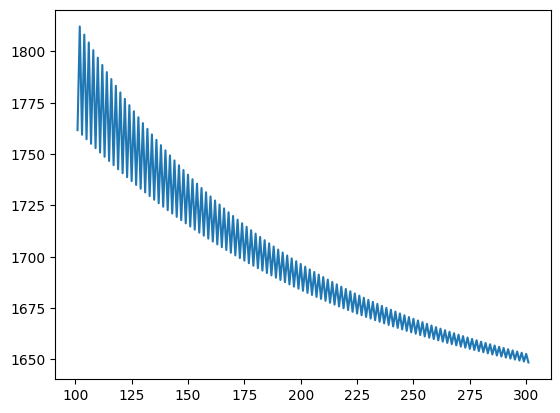

In [62]:
#plt.plot(day_new,scaler.inverse_transform(HDFC[5816:]))
plt.plot(day_pred,scaler.inverse_transform(HDFC_output))

In [63]:
HDFC_Pred = scaler.inverse_transform(HDFC_output).tolist()

#### Now Create the Model for HUL.

In [64]:
model_HUL=Sequential()
model_HUL.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model_HUL.add(LSTM(50,return_sequences=True))
model_HUL.add(LSTM(50))
model_HUL.add(Dense(1))
model_HUL.compile(loss='mean_squared_error',optimizer='adam')

In [65]:
model_HUL.fit(X_train_HUL,y_train_HUL,validation_data=(X_test_HUL,y_test_HUL),epochs=30,batch_size=64,verbose=1)

Epoch 1/30
64/64 [==============================] - 7s 33ms/step - loss: 0.0071 - val_loss: 0.0027
Epoch 2/30
64/64 [==============================] - 1s 16ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 3/30
64/64 [==============================] - 1s 22ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 4/30
64/64 [==============================] - 1s 23ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 5/30
64/64 [==============================] - 1s 19ms/step - loss: 0.0017 - val_loss: 0.0025
Epoch 6/30
64/64 [==============================] - 1s 16ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 7/30
64/64 [==============================] - 1s 16ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 8/30
64/64 [==============================] - 1s 16ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 9/30
64/64 [==============================] - 1s 16ms/step - loss: 0.0016 - val_loss: 0.0046
Epoch 10/30
64/64 [==============================] - 1s 16ms/step - loss: 0.0016 - val_loss: 0.0050
Epoch 11/

In [66]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train_HUL)
test_predict=model.predict(X_test_HUL)

53/53 [==============================] - 0s 6ms/step


In [67]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [69]:
### Calculate RMSE performance metrics
math.sqrt(mean_squared_error(y_train_HUL,train_predict))

1137.0984340707212

In [70]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test_HUL,test_predict))

2287.2703084299565

In [71]:
len(test_data_HUL)

1775

In [72]:
x_input=test_data_HUL[1675:].reshape(1,-1)
x_input.shape

(1, 100)

In [73]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [74]:
# demonstrate prediction for next 200 days

HUL_output=[]
n_steps=100
i=0
while(i<= 200):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        HUL_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        HUL_output.extend(yhat.tolist())
        i=i+1


print(HUL_output)

[0.8856871]
101
[[0.8856871128082275], [0.8396897315979004], [0.8838242292404175], [0.838372528553009], [0.8733908534049988], [0.8310407400131226], [0.8609955906867981], [0.8225142359733582], [0.848664402961731], [0.8138443827629089], [0.8368968963623047], [0.8053431510925293], [0.8257975578308105], [0.7971256971359253], [0.8153678178787231], [0.7892389297485352], [0.8055760860443115], [0.7816967964172363], [0.7963794469833374], [0.774495005607605], [0.7877308130264282], [0.7676205635070801], [0.7795841693878174], [0.7610564231872559], [0.771896243095398], [0.7547850608825684], [0.7646279335021973], [0.7487881779670715], [0.7577446103096008], [0.7430497407913208], [0.7512152194976807], [0.7375538945198059], [0.7450122833251953], [0.7322860360145569], [0.7391107082366943], [0.7272336483001709], [0.7334882020950317], [0.7223841547966003], [0.7281250357627869], [0.7177257537841797], [0.7230029106140137], [0.7132481336593628], [0.7181054353713989], [0.7089411616325378], [0.7134179472923279

In [75]:
day_new=np.arange(1,101)
day_pred=np.arange(101,302)

In [76]:
print(len(HUL))
print(len(HUL_output))

5916
201


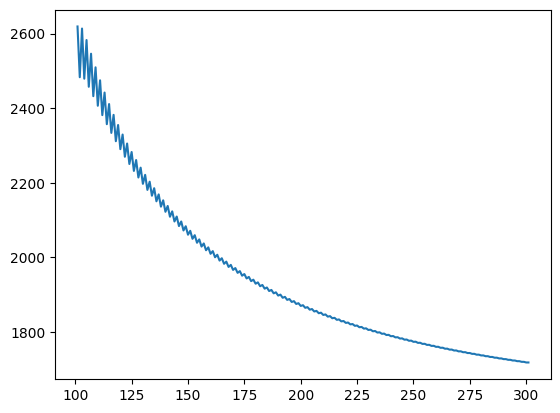

In [78]:
#plt.plot(day_new,scaler.inverse_transform(HUL[5816:]))
plt.plot(day_pred,scaler.inverse_transform(HUL_output))

In [79]:
HUL_Pred = scaler.inverse_transform(HUL_output).tolist()

In [81]:
Preds = {
    'HDFC Bank': HDFC_Pred,
    'Hindustan Uniliver': HUL_Pred
}
Pred_df = pd.DataFrame(Preds)

## Write the Prediction file to GDrive

In [90]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

# Define the output file path in Google Drive
output_file_path = '/content/drive/My Drive/Stock_Prediction.csv'

# Write the DataFrame to a CSV file in Google Drive
Pred_df.to_csv(output_file_path, index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
